# Image segmentation by a supervised learning 

In [1]:
import os
from pyexpat import model
import torch
from torchvision import transforms
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt
import statistics

In [2]:
from MyDataset import MyDataset
from MyModel import MyModel
torch.cuda.is_available()

True

## construct dataset for training (split=`mytrain` should be used)

In [34]:
dataset = MyDataset(path='../Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)', split='mytrain')
print('len(dataset)=', len(dataset))
len(set(dataset.raw_label))

  0%|          | 0/250712 [00:00<?, ?it/s]

len(dataset)= 250712


4803

## construct dataloader

In [4]:
batch_size = 256 # you can change this value
dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## plot the dataset

In [5]:
iter_data       = iter(dataloader)
(image, mask)   = next(iter_data)
print(image.shape, mask)
print(image.dtype, mask)
print(f'image : (min) = {image.min()}, (max) = {image.max()}')

torch.Size([256, 1, 50, 50]) tensor([2741, 3232, 3532, 2409, 2715, 2357, 4456,  230, 4685, 4611, 1004,  769,
        2377, 2983, 1751, 4560, 1147, 4026, 3216, 3856, 4489, 2942, 4766, 2965,
        1705,  533, 1337, 3984, 4481, 1605, 3785,  380, 2443,  893, 4295,   52,
         919, 1342, 4632, 3803, 3534, 1874,  336, 2794, 3599, 2637,  260, 1239,
         795, 3133, 1243, 3469, 2286, 3005,  633, 2936, 4058, 2712, 2807, 1440,
         448, 2272, 2832, 1417, 3799, 3431,  922, 1396, 3467, 1640, 4652, 2017,
        4097, 1759,  243, 1996, 2889,   61, 3666, 4732, 3318, 3571, 3895, 4416,
        3811, 2366, 1886, 3232, 3484, 3552,  447, 4237,  809, 3741, 4156, 4709,
        4741,  713, 1399, 2813, 4596, 2465, 2551, 4409, 2789, 4339, 3505, 4198,
        1108,  878,  352, 1297, 1268, 3158, 2843, 1041, 3819, 3944, 3229, 4183,
        3522,  441, 2046, 1724, 4575, 3785, 2072,  163, 3446, 3504, 4441,  624,
        4387, 2724,  932, 1701,  332, 2406, 2089, 2923, 2891, 4047, 4134, 4546,
        242

## plot images

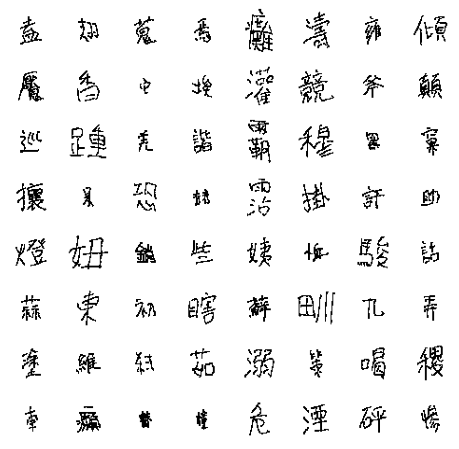

In [6]:
nRow = 8
nCol = 8
plt.figure(figsize=(nRow, nCol))
for i in range(nRow):
    for j in range(nCol):
        idx = nCol * i + j
        plt.subplot(nRow, nCol, idx+1)
        plt.axis('off')
        plt.imshow(image[idx].squeeze(0), cmap='gray')
plt.show()

## construct model

In [7]:
model       = MyModel()
size_model  = model.size()
pred        = model(image)
# print(f'image: {image.shape}')
# print(f'pred: {pred.shape}')
# print('model size =', size_model)
# print(f'image (min)={image.min()}, (max)={image.max()}')
# print(f'pred (min)={pred.min()}, (max)={pred.max()}')

In [8]:
from torchvision import models

def get_resnet_for_50x50(num_classes):
    # 1. ResNet18 불러오기 (Pretrained는 ImageNet(RGB) 기준이라 구조 변경 시 가중치 매칭이 까다로울 수 있어 False 추천)
    model = models.resnet18(weights=None) 
    
    # 2. [수정 포인트] 입력 채널을 3 -> 1로 변경
    # 원래 ResNet의 첫 conv1은 (3, 64, 7x7, stride=2)입니다.
    # 50x50 처럼 작은 이미지는 정보를 너무 많이 잃으므로 (1, 64, 3x3, stride=1)로 바꿉니다.
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # 3. 첫 번째 Pooling 제거 (선택 사항)
    # 50x50 이미지는 너무 작아지면 안 되므로 maxpool을 건너뛰게 할 수도 있습니다.
    # 여기서는 유지하되, 위에서 stride를 1로 줄여서 정보 손실을 막았습니다.
    
    # 4. 마지막 출력층(FC)을 우리 클래스 개수에 맞게 변경
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

## train

In [12]:
model = get_resnet_for_50x50(len(dataset.classes))

def compute_accuracy(prediction, label):
    pred_label = torch.argmax(prediction, dim=1)
    pred_label = pred_label.to(torch.uint8)
    label      = label.to(torch.uint8)
    bCorrect    = (pred_label == label)
    accuracy    = bCorrect.sum() / len(label)
    return accuracy

model.train()

num_epoch       = 10
loss_epoch      = []
accuracy_epoch  = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델 이동

criterion = nn.CrossEntropyLoss()
# Adam: 가장 무난하고 성능 좋은 최적화 도구 (Learning Rate=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
    loss_batch      = []
    accuracy_batch  = []

    for step, (data, label) in enumerate(tqdm(dataloader)):
        # print(data, label)
        optimizer.zero_grad()
        data = data.to(device)
        label = label.to(device)
        pred            = model(data)
        loss = criterion(pred, label)
        loss.backward()  # 기울기(Gradient) 계산
        optimizer.step()

        accuracy_value  = compute_accuracy(pred, label)
        accuracy_batch.append(accuracy_value.item())

    accuracy_epoch.append(statistics.mean(accuracy_batch))

    print(f'Epoch {epoch+1}/{num_epoch}, Accuracy: {accuracy_epoch[-1]}')


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 1/10, Accuracy: 0.04912937308478039


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 2/10, Accuracy: 0.6140952183350358


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 3/10, Accuracy: 0.8472732060776302


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 4/10, Accuracy: 0.9012105783963228


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 5/10, Accuracy: 0.9272336248723186


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 6/10, Accuracy: 0.9417015130234934


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 7/10, Accuracy: 0.9547010661389173


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 8/10, Accuracy: 0.9618990998467825


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 9/10, Accuracy: 0.9690133426966292


  0%|          | 0/979 [00:00<?, ?it/s]

Epoch 10/10, Accuracy: 0.9714751979060265


IndexError: index 88 is out of bounds for dimension 0 with size 88

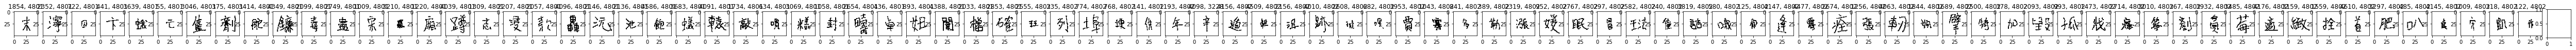

In [45]:
nRow = 1
nCol = batch_size 
plt.figure(figsize=(nCol, nRow))
for i in range(len(data.cpu())):
    plt.subplot(nRow, nCol, nCol * 0 + i + 1)
    plt.title(f'{label[i].cpu().item()}, {pred[i].cpu().argmax().item()}')
    plt.imshow(data[i].cpu().squeeze(0), cmap='gray')


In [59]:
print([dataset.idx2char[l.item()] for l in label])
print(mask.cpu()==pred.cpu().argmax(dim=1))

['末', '濘', '囚', '卞', '蛾', '亡', '籃', '劑', '舵', '鐮', '毒', '盡', '宋', '罷', '廂', '蹲', '志', '浸', '款', '轟', '沅', '池', '飽', '蟻', '轅', '敲', '喟', '糕', '封', '疇', '卓', '妞', '闈', '檔', '確', '玨', '列', '埠', '埂', '侏', '年', '辛', '遁', '靼', '沮', '跡', '瓏', '嘿', '賈', '寡', '多', '勒', '漲', '媛', '眠', '冒', '琺', '僮', '詰', '哦', '你', '逢', '霉', '痊', '張', '軔', '朔', '擘', '犄', '加', '毀', '孤', '戕', '癮', '箏', '剷', '貪', '莓', '適', '緻', '拴', '首', '肥', '叭', '速', '宋', '凱', '作', '囈', '狐', '侯', '舒', '計', '訪', '遵', '啦', '擅', '熨', '國', '票', '族', '鯧', '岑', '曲', '曹', '媾', '足', '咽', '逐', '延', '迷', '井', '鴣', '窯', '宮', '麥', '恨', '意', '啄', '龔', '派', '隅', '蛆', '要', '琊', '倪', '銅', '妣', '繕', '蒜', '藹', '暴', '兼', '坐', '蘸', '剷', '覦', '鼙', '蠶', '綾', '傻', '嘖', '丘', '遇', '端', '逖', '雀', '匱', '偃', '緬', '懼', '稀', '鎂', '禮', '梁', '衛', '坷', '兌', '況', '尹', '漪', '軻', '鏍', '寵', '僕', '惺', '濡', '狸', '慇', '笨', '忠', '撻', '膊', '翹', '赴', '睛', '訟', '訐', '慫', '晝', '囁', '函', '締', '弘', '涇', '鐃', '氾', '榆', '點', '泊', '凳', '娓', '返', '祉', '靠', '跎', '助', '冀', '聖', '刁',

## save the trained model

In [31]:
# 1. 모델을 CPU로 이동 (호환성 확보)
device = torch.device('cpu')
model.to(device)

# 2. 저장할 정보를 하나의 딕셔너리로 묶기
checkpoint = {
    'model_state_dict': model.state_dict(),  # 모델 가중치
    'classes': dataset.classes,              # 한자 리스트 (순서 중요!)
    'idx2char': dataset.idx2char             # 숫자->한자 매핑 딕셔너리
}

# 3. 파일로 저장
torch.save(checkpoint, 'recognition_model_final.pth')

print("모델과 매핑 정보가 'recognition_model_final.pth'에 저장되었습니다.")

모델과 매핑 정보가 'recognition_model_final.pth'에 저장되었습니다.


In [32]:
# model = get_resnet_for_50x50(len(dataset.classes))

# 2. 저장된 파일 로드
checkpoint = torch.load('recognition_model_final.pth', map_location='cpu')

# 3. 매핑 정보 복구
idx2char = checkpoint['idx2char']
classes = checkpoint['classes']

# 4. 모델 가중치 복구
# 저장된 모델의 클래스 개수와 선언한 모델의 클래스 개수가 맞아야 함
model = get_resnet_for_50x50(len(dataset.classes))
model.load_state_dict(checkpoint['model_state_dict'])

model.eval() # 추론 모드로 전환
print("모델 로드 완료! 이제 예측 가능합니다.")

모델 로드 완료! 이제 예측 가능합니다.


C:\Users\choi\AppData\Local\Temp\ipykernel_38268\921068510.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('recognition_model_final.pth', map_loc

In [44]:
batch_size  = 256
dataloader  = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
accs = []
for step, (image, mask) in enumerate(tqdm(dataloader)):
    image = image.to(device)
    mask = mask.to(device)
    pred = model(image)
    accuracy_value  = compute_accuracy(pred, mask)

    accs.append(accuracy_value)

print(f'IoU (train): {sum(accs)/len(accs)}')

  0%|          | 0/980 [00:00<?, ?it/s]

IoU (train): 0.9670682549476624


모델의 예측 결과: 鐵


c:\Users\choi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37941 (\N{CJK UNIFIED IDEOGRAPH-9435}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


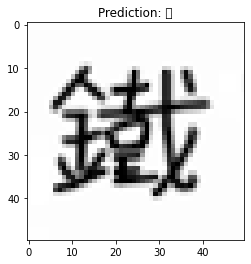

In [84]:
from PIL import Image
# 1. 이미지 불러오기 및 흑백 변환 (필수!)
# 학습할 때 흑백(1채널)으로 했으므로, 여기서도 꼭 .convert('L')을 해야 합니다.
my_image = Image.open('쇠_철_1.png').convert('L').resize((50, 50))

# 2. 전처리 정의 (학습 코드와 동일하게 맞춰야 함)
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),              # 0~255 값을 0~1 텐서로 변환
    transforms.Normalize([0.5], [0.5])  # -1~1 범위로 정규화
])

# 3. 이미지 변환 및 차원 추가
input_tensor = transform(my_image)      # (1, 50, 50)
input_tensor = input_tensor.unsqueeze(0) # (1, 1, 50, 50) -> 배치 차원 추가!

# 4. 장치(GPU/CPU) 맞추기
device = next(model.parameters()).device # 모델이 있는 곳으로 데이터도 이동
input_tensor = input_tensor.to(device)

# 5. 모델 예측
model.eval() # 평가 모드
with torch.no_grad():
    output = model(input_tensor)
    pred_idx = output.argmax().item() # 가장 높은 확률의 인덱스 추출

# 6. 결과 확인
# idx2char 딕셔너리가 메모리에 있다고 가정합니다.
pred_char = dataset.idx2char[pred_idx] 

print(f"모델의 예측 결과: {pred_char}")

# 시각화
plt.imshow(my_image, cmap='gray')
plt.title(f"Prediction: {pred_char}")
plt.show()

In [74]:
'鑿' in dataset.idx2char.values()

True